In [2]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity, block_diag
from scipy.sparse.linalg import spsolve, norm, inv, eigsh, eigs
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('text', usetex=True)

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import convolve
import time
import pickle
import numba 
from matplotlib.colors import ListedColormap
from skimage.transform import resize
from PIL import Image, ImageOps 
import cv2

In [98]:
def stopping_func(img, dim, domain, sgm=0.5, lmbd=1):
    blurred = gaussian_filter(img, sigma=sgm)
    f_sgm = blurred
    
    K_dx_minus  = np.array([
        [0,  0, 0],
        [-1, 1, 0],
        [0,  0, 0]
    ])
    K_dx_plus  = np.array([
        [0,  0, 0],
        [0, -1, 1],
        [0,  0, 0]
    ])
    K_dy_minus  = np.array([
        [0,  0, 0],
        [0,  1, 0],
        [0, -1, 0]
    ])
    K_dy_plus  = np.array([
        [0,  1, 0],
        [0, -1, 0],
        [0,  0, 0]
    ])
    dx_minus = convolve(f_sgm, K_dx_minus)
    dx_plus = convolve(f_sgm, K_dx_plus)
    dy_minus = convolve(f_sgm, K_dy_minus)
    dy_plus = convolve(f_sgm, K_dy_plus)

    norm_grad = np.sqrt( (np.maximum(dx_minus, 0)**2 + np.minimum(dx_plus, 0)**2) + (np.maximum(dy_minus, 0)**2 + np.minimum(dy_plus, 0)**2) )
    norm_grad[0, :] = 0
    norm_grad[-1, :] = 0
    norm_grad[:, 0] = 0
    norm_grad[:, -1] = 0
    
    g = 1 + (norm_grad**2) / (lmbd**2)
    g = 1/g
    
    return (g, blurred)

def signed_function(r, x0, dim, e=1):
    x = np.linspace(0, 1, num=dim[1])
    y = np.linspace(0, 1, num=dim[0])
    xx, yy = np.meshgrid(x, y)
    sgn = 1-2*(r*(dim[0]+dim[1])<np.sqrt(((xx-x0[0])*dim[1]/e)**2 + ((yy-x0[1])*dim[0])**2)).astype(int)
    dist = abs(r*(dim[0]+dim[1])-np.sqrt(((xx-x0[0])*dim[1]/e)**2 + ((yy-x0[1])*dim[0])**2))
    return sgn*dist

def A_B(un, a, domain, dim, tau, kappa):
    K_dx_minus  = np.array([
        [0,  0, 0],
        [-1, 1, 0],
        [0,  0, 0]
    ])
    K_dx_plus  = np.array([
        [0,  0, 0],
        [0, -1, 1],
        [0,  0, 0]
    ])
    K_dy_minus  = np.array([
        [0,  0, 0],
        [0,  1, 0],
        [0, -1, 0]
    ])
    K_dy_plus  = np.array([
        [0,  1, 0],
        [0, -1, 0],
        [0,  0, 0]
    ])
    dx_minus = convolve(un, K_dx_minus)
    dx_plus = convolve(un, K_dx_plus)
    dy_minus = convolve(un, K_dy_minus)
    dy_plus = convolve(un, K_dy_plus)

    norm_grad = np.sqrt( (np.maximum(dx_minus, 0)**2 + np.minimum(dx_plus, 0)**2) + (np.maximum(dy_minus, 0)**2 + np.minimum(dy_plus, 0)**2) )
    norm_grad[0, :]  = 0
    norm_grad[-1, :] = 0
    norm_grad[:, 0]  = 0
    norm_grad[:, -1] = 0

    K_x_minus  = np.array([
            [0,  0, 0],
            [1, 1, 0],
            [0,  0, 0]
        ])
    K_x_plus  = np.array([
            [0,  0, 0],
            [0, 1, 1],
            [0,  0, 0]
        ])
    K_y_minus  = np.array([
            [0, 0, 0],
            [0, 1, 0],
            [0, 1, 0]
        ])
    K_y_plus  = np.array([
            [0, 1, 0],
            [0, 1, 0],
            [0, 0, 0]
        ])

    x_minus = convolve(norm_grad, K_x_minus)
    x_plus = convolve(norm_grad, K_x_plus)
    y_minus = convolve(norm_grad, K_x_plus)
    y_plus = convolve(norm_grad, K_x_minus)
    
    mask_0 = np.isclose(norm_grad, 0)
    int_mask_0 = mask_0.astype(int)
    hm_x_minus = (2/(x_minus+int_mask_0)) 
    hm_x_minus[mask_0] = 0
    hm_x_plus = (2/(x_plus+int_mask_0)) 
    hm_x_plus[mask_0] = 0
    hm_y_minus = (2/(y_minus+int_mask_0)) 
    hm_y_minus[mask_0] = 0
    hm_y_plus = (2/(y_plus+int_mask_0)) 
    hm_y_plus[mask_0] = 0

    hm_sum = hm_x_minus + hm_x_plus + hm_y_minus + hm_y_plus

    def get_A_row(row):
        px = row
#         print(row, a.shape, norm_grad.shape, hm_sum.shape)
        D   = (- a * norm_grad * hm_sum    )[px, :]
        D1  = (  a * norm_grad * hm_x_plus )[px, :-1]
        D_1 = (  a * norm_grad * hm_x_minus)[px, 1:]
        k = np.array([D_1, D, D1], dtype= object)
        offset = [-1, 0, 1]
        return diags(k, offset)

    def get_A_star_row(row, star):
        px = row
        if star == 1: D = ( a * norm_grad * hm_y_plus )[px, :]
        elif star == -1: D = ( a * norm_grad * hm_y_minus)[px, :]
        k = D
        offset = 0
        return diags(k, offset)

    D   = [ get_A_row(row) for row in range( dim[0] ) ]                                                    
    D1  = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=1) for row in range( dim[0] - 1 ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]
    D_1 = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=-1) for row in range(1, dim[0] ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]

    A0 = block_diag(D)
    A1 = csr_matrix(block_diag(D1).todense()[dim[1]:,:-dim[1]])
    A2 = csr_matrix(block_diag(D_1).todense()[:-dim[1],dim[1]:])

    I = csr_matrix(np.eye(dim[0]*dim[1]))
    A_star = I - (tau * csr_matrix(A0+A1+A2))

    B_star = np.ravel(un + tau*kappa*norm_grad*a)

    return A_star, B_star
    
class LevelSetMethod(object):
    def __init__(self, id_name="test"):
        self.id_name = id_name
    
    def set_image(self, img: np.array, reshape=True, norm=True):
        self.img = img
        self.dim = np.array([img.shape[_] for _ in range(2)])
        print(f"""<set_image> img: {type(img)}, reshape: {reshape}, norm: {norm}""")
        self.minmax = np.min(img), np.max(img)
        print(f"""|img_dim:     {self.dim}\n|img_min/max: {self.minmax}""")

        if reshape:
            xy_dim_max = np.argmax(self.dim)
            if self.dim[xy_dim_max] > 100:
                w, h = np.array([int(self.dim[_]*100/self.dim[xy_dim_max]) for _ in range(2)])
                self.img = resize(img, (w, h), anti_aliasing=True)
                self.dim = np.array([w, h])
                self.minmax = np.min(self.img), np.max(self.img)
                print(f"""|new_img_min/max(resize): {self.minmax}""")
                print(f"""|new_dim:     {self.dim}""")
        self.domain = [
            (x, y) for x in range( self.dim[0] ) for y in range( self.dim[1] )
        ]

        if norm:
            self.img = (255*(self.img - self.minmax[0]) / (self.minmax[1] - self.minmax[0])).astype(int)
            self.minmax = np.min(self.img), np.max(self.img)
            print(f"""|new_img_min/max(norm): {self.minmax}""")
        print(f"""|size_domain: {len(self.domain)}""")
        print("""</set_image>""")
    
    def show_image(self, grid=False):
        plt.imshow(self.img, cmap="gray")
        if grid:
            plt.grid(color='blue', linestyle='-', linewidth=1)
        plt.title(self.id_name, size=18)
    
    def eval_stopfunct(self, list_sgm: np.array, list_lmbd: np.array, cmap="plasma_r"):
        fig, ax = plt.subplots(3, 4, figsize=(4*3, 3*3), constrained_layout=False)
        for i, sgm in enumerate(list_sgm):
            for j, lmbd in enumerate(list_lmbd):
                g, blurred = stopping_func(self.img, self.dim, self.domain, sgm=sgm, lmbd=lmbd)
                if j == 0:
                    im = ax[i, 0].imshow(blurred, cmap='gray')
                    ax[i, 0].set_xticks([])
                    ax[i, 0].set_yticks([])
                    ax[i, 0].set_ylabel(f"sigma={sgm}", fontsize=18)
                ax[i, j+1].set_title(f"({sgm}, {lmbd})", fontsize=18)
                im = ax[i, j+1].imshow(g, cmap=cmap)
                ax[i, j+1].set_xticks([])
                ax[i, j+1].set_yticks([])
                if i == 2:
                    if j == 0: ax[i, 0].set_xlabel(f"Desenfoque gaussiano", fontsize=18)
                    ax[i, j+1].set_xlabel(f"lambda={lmbd}", fontsize=18)  
        plt.suptitle(f"Funcion de parada con desenfoque gaussiano de sigma\n en {list_sgm} y factor de contraste lambda en {list_lmbd}", size=18*1.5)
        fig.tight_layout(h_pad=0.1, w_pad=0.1)
    def set_stopfunct(self, sgm, lmbd):
        print(f"""<set_stopfunct> sigma: {sgm}, lambda: {lmbd}""")
        self.sgm = sgm
        self.lmbd = lmbd
        self.g, self.blurred = stopping_func(self.img, self.dim, self.domain, sgm=sgm, lmbd=lmbd)
        gauss_minmax = np.min(self.blurred), np.max(self.blurred)
        stopfunct_minmax = np.min(self.g), np.max(self.g)
        print(f"""|gauss_min/max: {gauss_minmax}\n|stopfunct_min/max:     {stopfunct_minmax}""")
        print(f"""</set_stopfunct>""")
        
    def eval_sgndist(self, c, r, e, cmap="RdGy_r"):
        u = signed_function(r, c, self.dim, e)

        fig, ax = plt.subplots(1, 2, figsize=(5*2, 5), constrained_layout=True, gridspec_kw={"width_ratios": [1, 1]})

        cv = self.img.copy()
        cv[u<0] = -np.max(cv)
        ax[0].imshow(cv, cmap=cmap)
        ax[0].set_xticks([])
        ax[0].set_yticks([]);
        ax[0].set_xlabel("Mascara", size=18)

        ax[1].imshow(u, cmap=cmap)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_xlabel("Distancia con signo", size=18)

        plt.suptitle(f"Distancia con signo de la elipse \nde radio {r} centrada en {c} con excentricidad {e}", size=18*1.5);
    
    def set_sgndist(self, c, r, e):
        print(f"""<set_sgndist> centro: {c}, radio: {r}, excentricidad: {e}""")
        self.c, self.r, self.e = c, r, e
        self.u0 = signed_function(r, c, self.dim, e)
        print(f"""</set_sgndist>""")
    
    def show_setting(self, cmap_stopfunct = "plasma_r", cmap_sgndist = "RdGy_r"):
        fig, ax = plt.subplots(1, 5, figsize=(5*3, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 1, 1, 1, 1]})

        ax[0].imshow(self.img, cmap="gray")
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_xlabel(f"Imagen original", size=18)

        im = ax[1].imshow(self.blurred, cmap="gray")
        ax[1].set_xticks([])
        ax[1].set_yticks([]);
        ax[1].set_xlabel("Desenfoque gaussiano", size=18)

        im = ax[2].imshow(self.g, cmap=cmap_stopfunct)
        ax[2].set_xticks([])
        ax[2].set_yticks([]);
        ax[2].set_xlabel("Funcion de parada", size=18)

        im = ax[3].imshow(self.u0, cmap=cmap_sgndist)
        ax[3].set_xticks([])
        ax[3].set_yticks([])
        ax[3].set_xlabel("Distancia con signo", size=18)

        cv0 = self.u0>0
        ax[4].imshow(cv0, cmap=ListedColormap(['black','tab:red']))
        ax[4].set_xticks([])
        ax[4].set_yticks([]);
        ax[4].set_xlabel("Conjunto de nivel positivo", size=18)

        plt.suptitle(f"Imagen ({self.id_name}), suavizada de parámetro sigma={self.sgm}, funcion de parada con parámetro lambda={self.lmbd} y\nDistancia con signo de la elipse de excentricida {self.e} centrada en {self.c} con radio {self.r}", size=18*1.5);
    
    def print_setting(self):
        print("""<print_setting>""")
        print(f"""|sigma: {self.sgm}\n|lambda: {self.lmbd}\n|centro: {self.c}\n|radio: {self.r}\n|excentricidad: {self.e}""")
        print("""</print_setting>""")
    
    def show_solution(self, show_iters: list):
        iterations = self.iterations

        fig, ax = plt.subplots(2, 3, figsize=(3*3.5, 3.5*2), constrained_layout=False, gridspec_kw={"width_ratios": [1, 1, 1]})
        
        cmap_sgndist = "RdGy_r"

        for k, iter_k in enumerate(show_iters):
            # Funciones
            im = ax[0, k].imshow(iterations[iter_k], cmap=cmap_sgndist)
            ax[0, k].set_xticks([])
            ax[0, k].set_yticks([])
            ax[0, k].set_title(f"Iteración {iter_k}", size=18)

            # Curvas
            im = ax[1, k].imshow((iterations[iter_k]>0), cmap=ListedColormap(['black','tab:red']))
            ax[1, k].set_xticks([])
            ax[1, k].set_yticks([])

            if k == 0:
                ax[0, 0].set_ylabel("Función solución", size=18)
                ax[1, 0].set_ylabel("Conjunto de nivel\npositivo", size=18)

        plt.suptitle(f"Resultados para la iteraciones\n{show_iters}", size=18*1.5)
        fig.tight_layout(h_pad=0.01, w_pad=0.5)
        
    def solve(self, n_iter, tau, k, save_rate=10, root_path_save=None, show_log_rate=1):
        self.n_iter = n_iter
        self.tau = tau
        self.k = k
        print(f"""<solve> N° iteraciones: {n_iter}, discretizacion en tiempo: {tau}, constante k: {k}""")
        
        dic_params = {
            "sgm": self.sgm,
            "lmbd": self.lmbd, 
            "tau": self.tau,
            "k": self.k
        }
        id_params = "__".join([f"{t[0]}_{t[1]}".replace(".", "_") for t in dic_params.items()])
        self.path_save_file = root_path_save+f"/{self.id_name}__iterations_times__{id_params}"
        print(f"""|path_save_file: {self.path_save_file}""")
            
        domain = self.domain
        dim = self.dim
        g = self.g
        
        start = time.time()
        A0_star, B0_star = A_B(self.u0, g, domain, dim, tau, k)
        end = time.time()
        
        un = self.u0
        self.iterations = [un]
        self.times = [end-start]

        n = 0
        while n < n_iter:
            start = time.time()
            An_star, Bn_star = A_B(un, g, domain, dim, tau, k)
            un1 = spsolve(An_star, Bn_star)
            un1 = un1.reshape( (self.dim[0], self.dim[1]) )
            cvn = un1>0
            
            if (n+1==n_iter) or (n%save_rate)==0:
                pickle.dump([self.iterations, self.times], open(self.path_save_file+".pickle", "wb"))

            un = un1
            
            self.iterations.append(un)
            end = time.time()

            self.times.append(end-start)
            if n%show_log_rate==0:
                print(f"""|Iter: {n+1}, T iter: {self.times[-1]:.1f}s, T trans: {np.sum(self.times): .1f}s, T per iter: {np.mean(self.times):.1f}s p/m {np.std(self.times): .1f}s, T rest: {np.mean(self.times) * (n_iter-n): .1f}s p/m {np.std(self.times)* np.sqrt(n_iter-n): .1f}s""")
            n += 1
        print("""</solve>""")

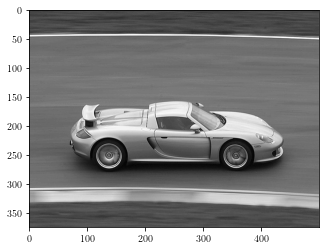

In [177]:
img_o = Image.open("dataset/database_pascal/2008_002710.jpg").convert("L")

dim = (img_o.size[1], img_o.size[0])
img = np.array(img_o.getdata()).reshape((dim[0], dim[1]))

plt.imshow(img, cmap="gray")

<set_image> img: <class 'numpy.ndarray'>, reshape: True, norm: True
|img_dim:     [375 500]
|img_min/max: (0, 255)
|new_img_min/max(resize): (4.8665180264701204e-09, 1.1279159586871433e-07)
|new_dim:     [ 75 100]
|new_img_min/max(norm): (0, 255)
|size_domain: 7500
</set_image>
Wall time: 31.9 ms


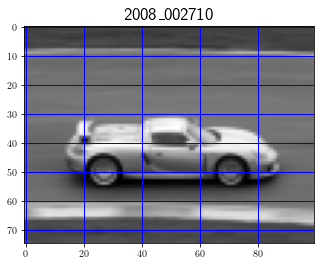

In [178]:
%%time
segmentator = LevelSetMethod(id_name="2008_002710")
segmentator.set_image(
    img, 
    reshape=True,
    norm=True
)
segmentator.show_image(grid=True)

Wall time: 2.68 s


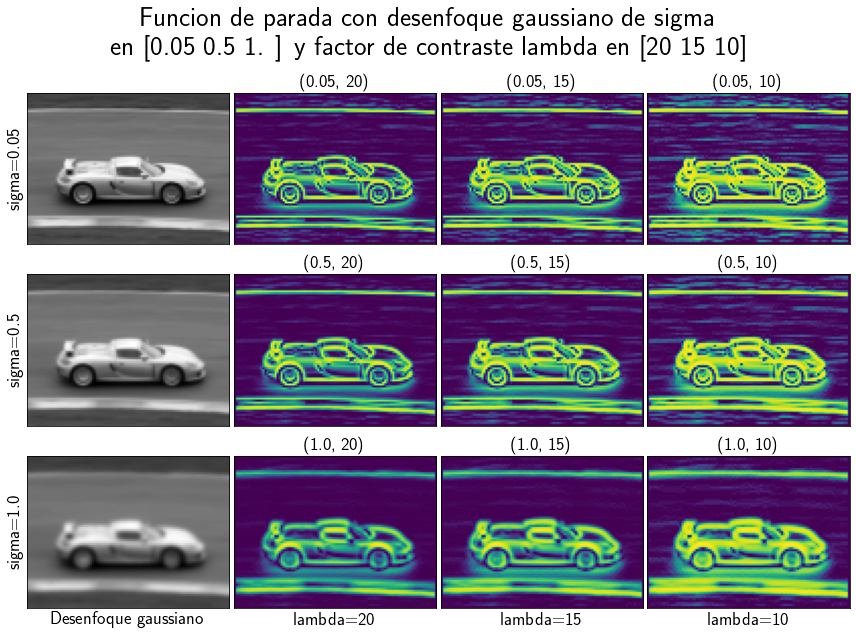

In [180]:
%%time
segmentator.eval_stopfunct(
    list_sgm=np.array([0.05, 0.5, 1]), 
    list_lmbd=np.array([20, 15, 10]),
    cmap="viridis_r"
)

In [181]:
%%time
segmentator.set_stopfunct(
    sgm=0.5, 
    lmbd=20,
)

<set_stopfunct> sigma: 0.5, lambda: 20
|gauss_min/max: (1, 249)
|stopfunct_min/max:     (0.025477707006369428, 1.0)
</set_stopfunct>
Wall time: 2.96 ms


Wall time: 38.9 ms


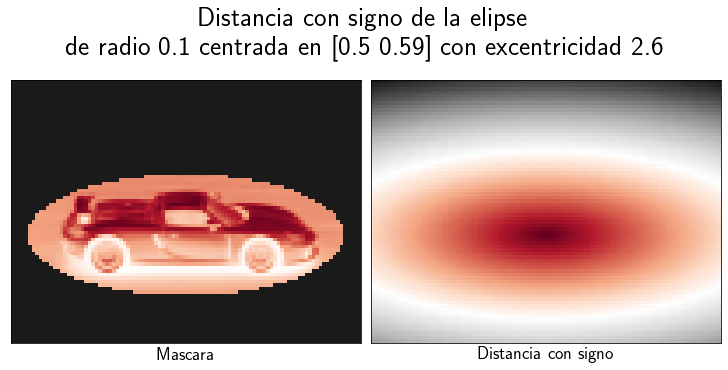

In [192]:
%%time
segmentator.eval_sgndist(
    c=np.array([0.5, 0.59]), 
    r=0.10,
    e=2.6
)

In [193]:
%%time
segmentator.set_sgndist(
    c=np.array([0.5, 0.59]), 
    r=0.10,
    e=2.6
)

<set_sgndist> centro: [0.5  0.59], radio: 0.1, excentricidad: 2.6
</set_sgndist>
Wall time: 1.99 ms


Wall time: 83.8 ms


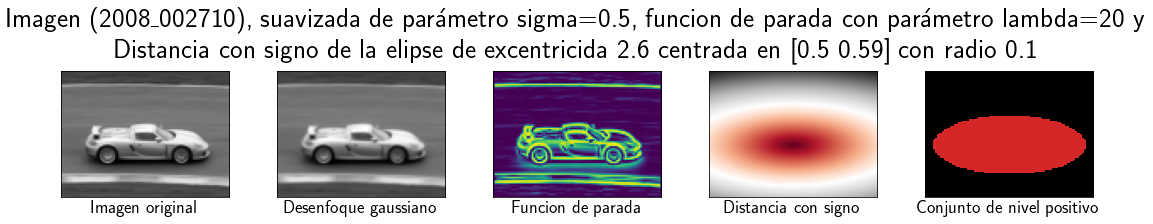

In [194]:
%%time 
segmentator.show_setting(cmap_stopfunct="viridis_r")

In [195]:
%%time 
segmentator.print_setting()

<print_setting>
|sigma: 0.5
|lambda: 20
|centro: [0.5  0.59]
|radio: 0.1
|excentricidad: 2.6
</print_setting>
Wall time: 0 ns


In [196]:
%%time
segmentator.solve(
    n_iter = 50,
    tau = 0.25,
    k = -2,
    save_rate=10,
    root_path_save="results",
    show_log_rate=5
)

<solve> N° iteraciones: 50, discretizacion en tiempo: 0.25, constante k: -2
|path_save_file: results/2008_002710__iterations_times__sgm_0_5__lmbd_20__tau_0_25__k_-2
|Iter: 1, T iter: 2.6s, T trans:  5.2s, T per iter: 2.6s p/m  0.0s, T rest:  130.0s p/m  0.1s
|Iter: 6, T iter: 2.6s, T trans:  18.1s, T per iter: 2.6s p/m  0.0s, T rest:  116.3s p/m  0.2s
|Iter: 11, T iter: 2.6s, T trans:  31.0s, T per iter: 2.6s p/m  0.0s, T rest:  103.3s p/m  0.1s
|Iter: 16, T iter: 2.6s, T trans:  43.8s, T per iter: 2.6s p/m  0.0s, T rest:  90.3s p/m  0.1s
|Iter: 21, T iter: 2.6s, T trans:  56.8s, T per iter: 2.6s p/m  0.0s, T rest:  77.4s p/m  0.1s
|Iter: 26, T iter: 2.5s, T trans:  69.6s, T per iter: 2.6s p/m  0.0s, T rest:  64.5s p/m  0.1s
|Iter: 31, T iter: 2.5s, T trans:  82.5s, T per iter: 2.6s p/m  0.0s, T rest:  51.5s p/m  0.1s
|Iter: 36, T iter: 2.6s, T trans:  95.3s, T per iter: 2.6s p/m  0.0s, T rest:  38.6s p/m  0.1s
|Iter: 41, T iter: 2.6s, T trans:  108.2s, T per iter: 2.6s p/m  0.0s, T re

Wall time: 143 ms


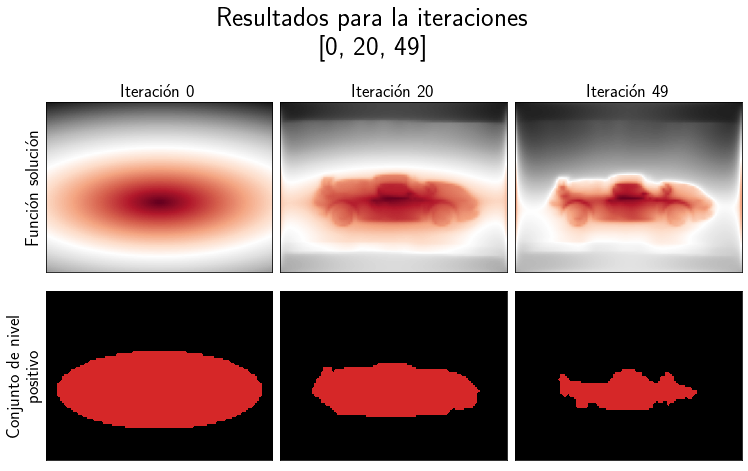

In [197]:
%%time
segmentator.show_solution(
    show_iters=[0, 20, 49]
)

In [214]:
def get_groud_truth(id_name):
    img_r = Image.open(f"dataset/database_pascal/{id_name}.png").convert("L")

    dim_r = (img_r.size[1], img_r.size[0])

    if dim_r[0]>100:
        basewidth = 100
        wpercent = (basewidth/float(img_r.size[0]))
        hsize = int((float(img_r.size[1])*float(wpercent)))
        img_r = img_r.resize((basewidth,hsize), Image.ANTIALIAS)


    dim_r = (img_r.size[1], img_r.size[0])

    img_r = ImageOps.posterize(img_r, 4)
    img_r = np.array(img_r.getdata()).reshape((dim_r[0], dim_r[1]))
    img_r = (255*(img_r-np.min(img_r))/(np.max(img_r)-np.min(img_r))).astype(int)

    img_r = ((img_r>np.mean(img_r))).astype(int)
    return img_r

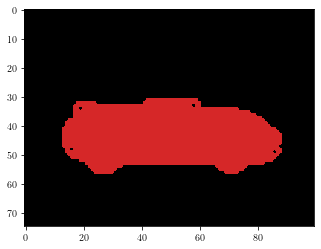

In [221]:
img_r = get_groud_truth(segmentator.id_name)
plt.imshow(img_r, cmap=ListedColormap(['black','tab:red']));

In [200]:
def precision_recall(y_real, y_pred, pos_label=1):
    tp = np.sum( (y_real==y_pred) & (y_pred==pos_label) )
    p = np.sum( y_real==pos_label )
    recall = tp/p
    
    fn = np.sum( (y_real!=y_pred) & (y_pred==pos_label) )
    precision = tp/(tp+fn)
    
    return precision, recall

In [218]:
def plot_precision_recall(img_r, iterations):
    clf = [(un>0).astype(int) for un in iterations]
    precision_recall_curve = [precision_recall(img_r, clf_k, pos_label=1) for clf_k in clf]
    precision = np.array([prc_k[0] for prc_k in precision_recall_curve])
    recall = np.array([prc_k[1] for prc_k in precision_recall_curve])
    best_iter= np.argmax((2*precision*recall)/(precision+recall))
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(precision, recall, c=range(len(precision_recall_curve)), cmap="plasma")
    ax.scatter([precision[best_iter]], [recall[best_iter]], c="red", s=50, label=f"Iter: {best_iter}\nRecall: {100*recall[best_iter]: .1f}\%\nPrecision: {100*precision[best_iter]: .1f}\%")
    ax.set_yticks(np.linspace(3/4, 1, 5).round(2));
    ax.set_xticks(np.linspace(3/4, 1, 5).round(2));
    plt_eps = 0.01
    plt.xticks(fontsize=18*0.8)
    plt.yticks(fontsize=18*0.8)
    ax.set_xlim([3/4-plt_eps, 1+plt_eps])
    ax.set_ylim([3/4-plt_eps, 1+plt_eps])
    ax.set_ylabel("Recall", fontsize=18)
    ax.set_xlabel("Precision", fontsize=18)
    plt.grid()
    ax.legend(fontsize=18*0.8, loc=3)
    ax.set_title("Precision vs Recall", fontsize=18*1.5);
    plt.gca().set_aspect('equal')

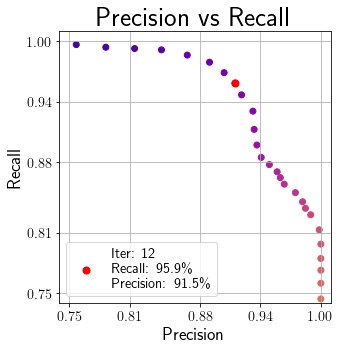

In [219]:
plot_precision_recall(img_r, segmentator.iterations)

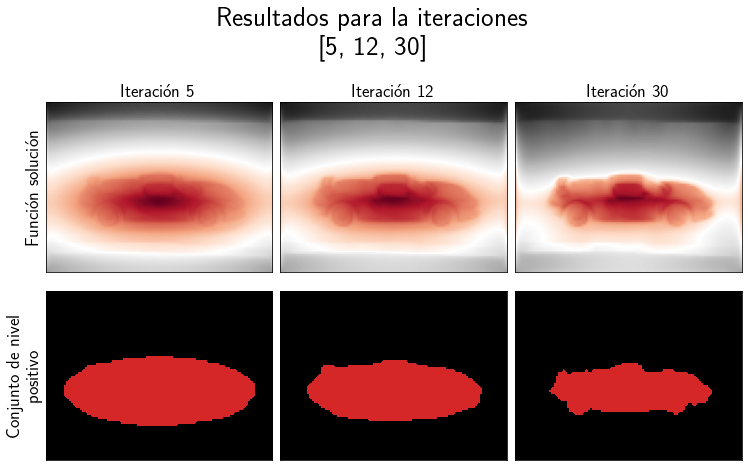

In [220]:
segmentator.show_solution(
    show_iters=[5, 12, 30]
)